# HW 10 CLUSTERING BUSINESS

In [146]:
import pandas as pd
import geopandas as gp
import numpy as np
import zipfile

import matplotlib as plt
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Used following commands to get the data in the folder:
!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\\totals.zip; done

In [101]:
NYCzipcode_shape = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
print(NYCzipcode_shape.columns)  #printing the names of columns
NYCzipcode_shape.head()

Index([           u'@id', u'BLDGpostalCode',       u'CTY_FIPS',
             u'OBJECTID',        u'PO_NAME',          u'STATE',
              u'ST_FIPS',     u'Shape_Area',     u'Shape_Leng',
              u'borough',       u'geometry',     u'postalCode'],
      dtype='object')


,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [102]:
NYCzipcode_shape.drop([  u'@id', u'BLDGpostalCode', u'ST_FIPS', u'STATE',   u'PO_NAME', u'CTY_FIPS',
             u'OBJECTID', u'Shape_Area', u'Shape_Leng'], axis = 1, inplace = True) #dropping coloumns not in need
NYCzipcode_shape = NYCzipcode_shape.rename(columns={'postalCode' : 'zip'}) #replacing the name postalcode with zip for futureuse
NYCzipcode_shape['zip'] = pd.to_numeric(NYCzipcode_shape['zip'])
NYCzipcode_shape.head()

,borough,geometry,zip
0,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [103]:
#since we have the business data from 1994 to 2014, we collect it in dataframes and merge it with zipcodes shape dataframe
for i in range(1994,2015):
    i = str(i)
    i = i[2:]
    zf = zipfile.ZipFile('zbp' + str(i) + 'totals.zip')
    df = pd.read_csv(zf.open('zbp' + str(i) + 'totals.zip'.replace('.zip','.txt')))
    df.columns = map(str.lower, df.columns)
    df = df[['zip', 'est']]
    df = df.rename(columns={'est' : 'est' + str(i)})
    NYCzipcode_shape = NYCzipcode_shape.merge(df, on = 'zip')

print(NYCzipcode_shape.shape)    
NYCzipcode_shape.head()

(243, 24)


,borough,geometry,zip,est94,est95,est96,est97,est98,est99,est00,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1229,1236,1292,1309,1351,1376,1409,...,1539,1527,1545,1538,1572,1629,1647,1724,1759,1768
1,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,194,188,176,192,194,186,189,...,225,226,238,227,233,229,222,241,241,250
2,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1422,1414,1335,1344,1344,1350,1350,...,1441,1454,1488,1503,1475,1494,1488,1510,1539,1534
3,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,326,219,209,198,203,217,213,...,226,226,228,226,237,248,256,266,258,260
4,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,492,476,483,522,509,519,553,...,604,608,617,616,628,643,677,679,714,731


#### To remove the correlation in the features, we will Whiten the data. Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.

In [104]:
mean_est = NYCzipcode_shape.iloc[:,range(3,24)].mean(axis = 1)
std_est = NYCzipcode_shape.iloc[:,range(3,24)].std(axis = 1)
NYCzipcode_shape.iloc[:,range(3,24)] = NYCzipcode_shape.iloc[:,range(3,24)].apply(lambda x: (x-mean_est)/std_est)
NYCzipcode_shape.head()

,borough,geometry,zip,est94,est95,est96,est97,est98,est99,est00,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,-1.650515,-1.607088,-1.259673,-1.154208,-0.893647,-0.738551,-0.533825,...,0.272673,0.198227,0.309896,0.266469,0.477400,0.831018,0.942687,1.420382,1.637516,1.693350
1,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,-0.974535,-1.248013,-1.794968,-1.065695,-0.974535,-1.339172,-1.202433,...,0.438432,0.484012,1.030967,0.529592,0.803069,0.620751,0.301694,1.167706,1.167706,1.577923
2,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,-0.118051,-0.234030,-1.379327,-1.248850,-1.248850,-1.161866,-1.161866,...,0.157401,0.345867,0.838780,1.056241,0.650313,0.925765,0.838780,1.157723,1.578149,1.505662
3,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,3.212291,-0.444253,-0.785986,-1.161892,-0.991026,-0.512600,-0.649293,...,-0.205040,-0.205040,-0.136693,-0.205040,0.170867,0.546773,0.820159,1.161892,0.888506,0.956853
4,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,-1.332578,-1.549090,-1.454366,-0.926619,-1.102534,-0.967215,-0.507127,...,0.183004,0.237132,0.358920,0.345388,0.507772,0.710751,1.170839,1.197903,1.671522,1.901566


#### To know about the number of clusters, we will use silhoutte score and elbow  method to confirm the selection of clusters.

In [106]:
X = NYCzipcode_shape.iloc[:, range(3,24)]
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.572142801777
For n_clusters =3, the average silhouette_score is :0.541435020202
For n_clusters =4, the average silhouette_score is :0.495601550463
For n_clusters =5, the average silhouette_score is :0.478801351965
For n_clusters =6, the average silhouette_score is :0.234252779225
For n_clusters =7, the average silhouette_score is :0.269653212641
For n_clusters =8, the average silhouette_score is :0.1408578891
For n_clusters =9, the average silhouette_score is :0.20686549319


#### As per the Silhouette score, the optimal number of clusters can be 2. Let's see how many clusters elbow method gives us.

In [107]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

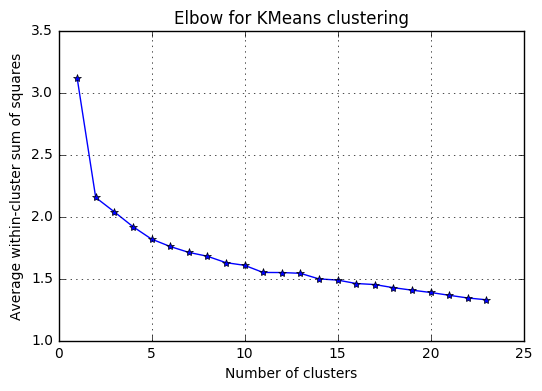

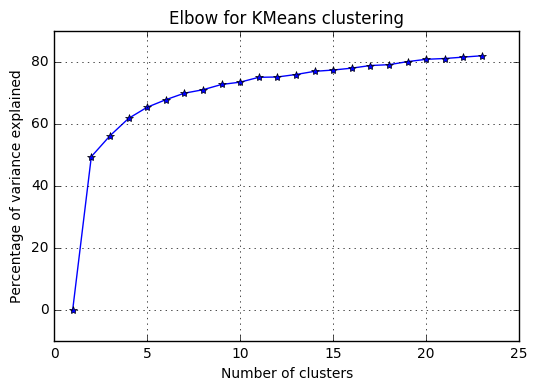

In [108]:
elbow(NYCzipcode_shape.iloc[:, range(3,24)], range(1,24))

#### So from the above plots,  we can see elbow also gives u Number of clusters = 2. Hence, we can select k = 2

### So, using KMeans with number of clusters = 2

In [121]:
#KMeans cluster
kmeans_cluster = KMeans(2).fit(NYCzipcode_shape.iloc[:, range(3,24)])
centers = kmeans_cluster.cluster_centers_
NYCzipcode_shape['km_labels'] = kmeans_cluster.labels_
len(centers)

2

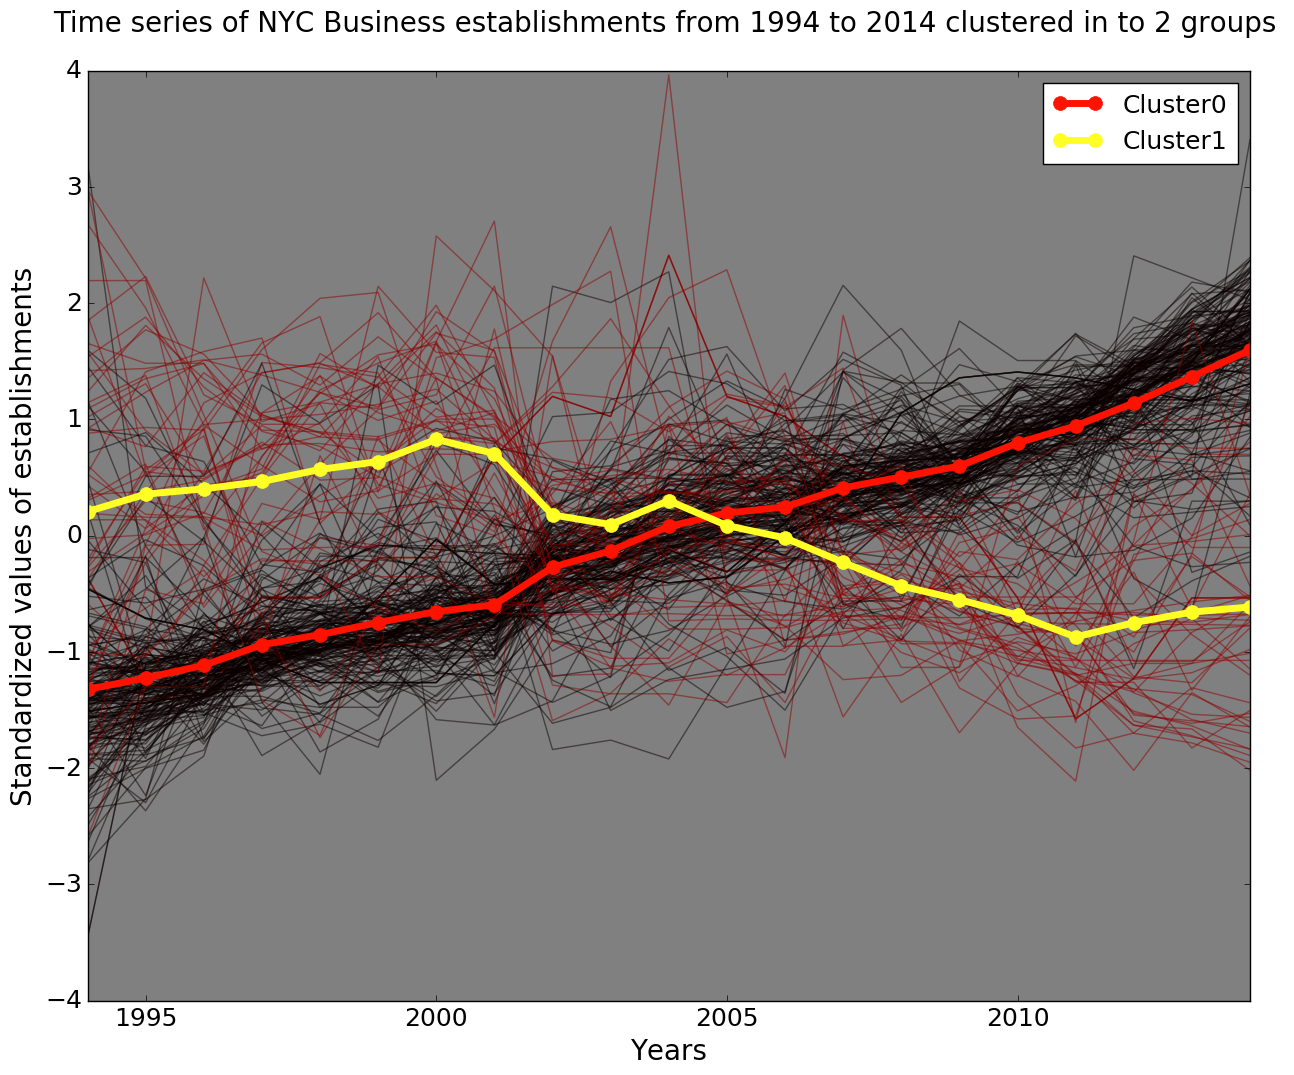

In [135]:
#Plotting timeseries of 
fig = plt.figure(figsize=(15,12))
ax = fig.gca()
ax.set_axis_bgcolor("grey")
for i in range(len(NYCzipcode_shape)):
    ax.plot(range(1994,2015), NYCzipcode_shape.iloc[i,range(3,24)], 
            '-', lw = 1, alpha = 0.5, c=cm.hot(NYCzipcode_shape.km_labels[i]*50) )
plt.xlim(1994,2014)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Years", fontsize=20)
plt.ylabel("Standardized values of establishments", fontsize=20)
plt.title('Time series of NYC Business establishments from 1994 to 2014 clustered in to 2 groups \n', 
          fontsize=20)
clusters = range(len(centers))
for i in range(len(centers)):
    cluster, = plt.plot(range(1994,2015),centers[i], 
              '.-', ms = 20, lw = 5, c=cm.hot((i+1)*100), label = "Cluster" + str(i) )
    clusters[i] = (cluster)
plt.legend(handles=[clusters[i] for i in range(len(centers))], fontsize = 18, 
           loc = 'best')
plt.show()

#### Figure 1: Time series of number of business establishments in different zipcodes in NYC from 1994 to 2014. The time series of the zipcodes is standarized and clustered into 2 groups. The red line indicates an increase in business establishments over the years and the yellow line indicates a downward trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


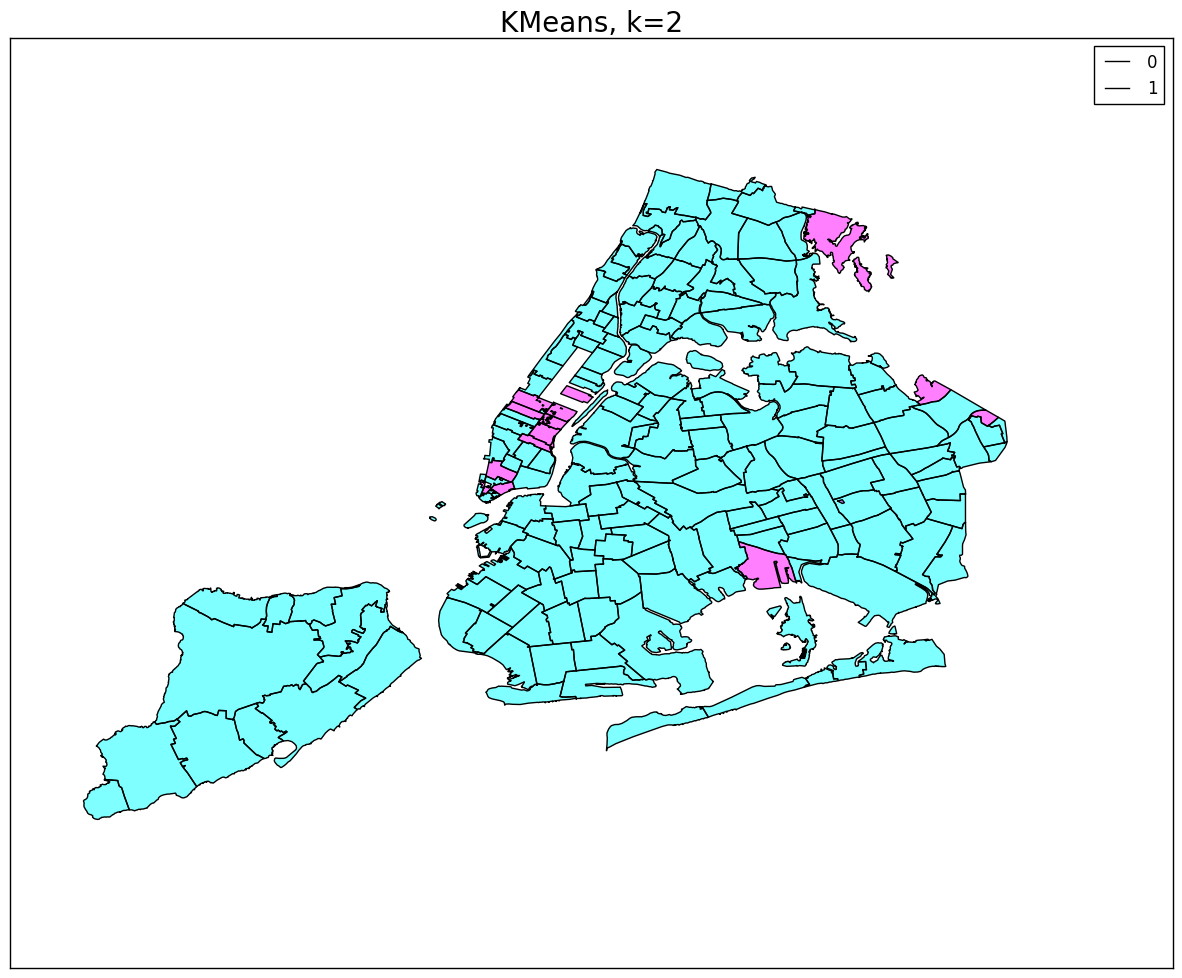

In [136]:
#Plotting KMeans cluster 
f, ax = plt.subplots(figsize=(15,12))
NYCzipcode_shape.plot(colormap='cool', column='km_labels', ax = ax)
ax.set_title("KMeans, k=2", fontsize=20)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend(NYCzipcode_shape.km_labels.unique())

In [139]:
# CLustering data by using Agglomerative clustering
agc2 = AgglomerativeClustering(n_clusters=2, 
                              compute_full_tree=True).fit(NYCzipcode_shape.iloc[:, range(3,24)])
agg2_labels = agc2.labels_
NYCzipcode_shape['agg2_labels'] = agc2.labels_

And if you use hierarchical clustering and make a dandrogram it may look like this`

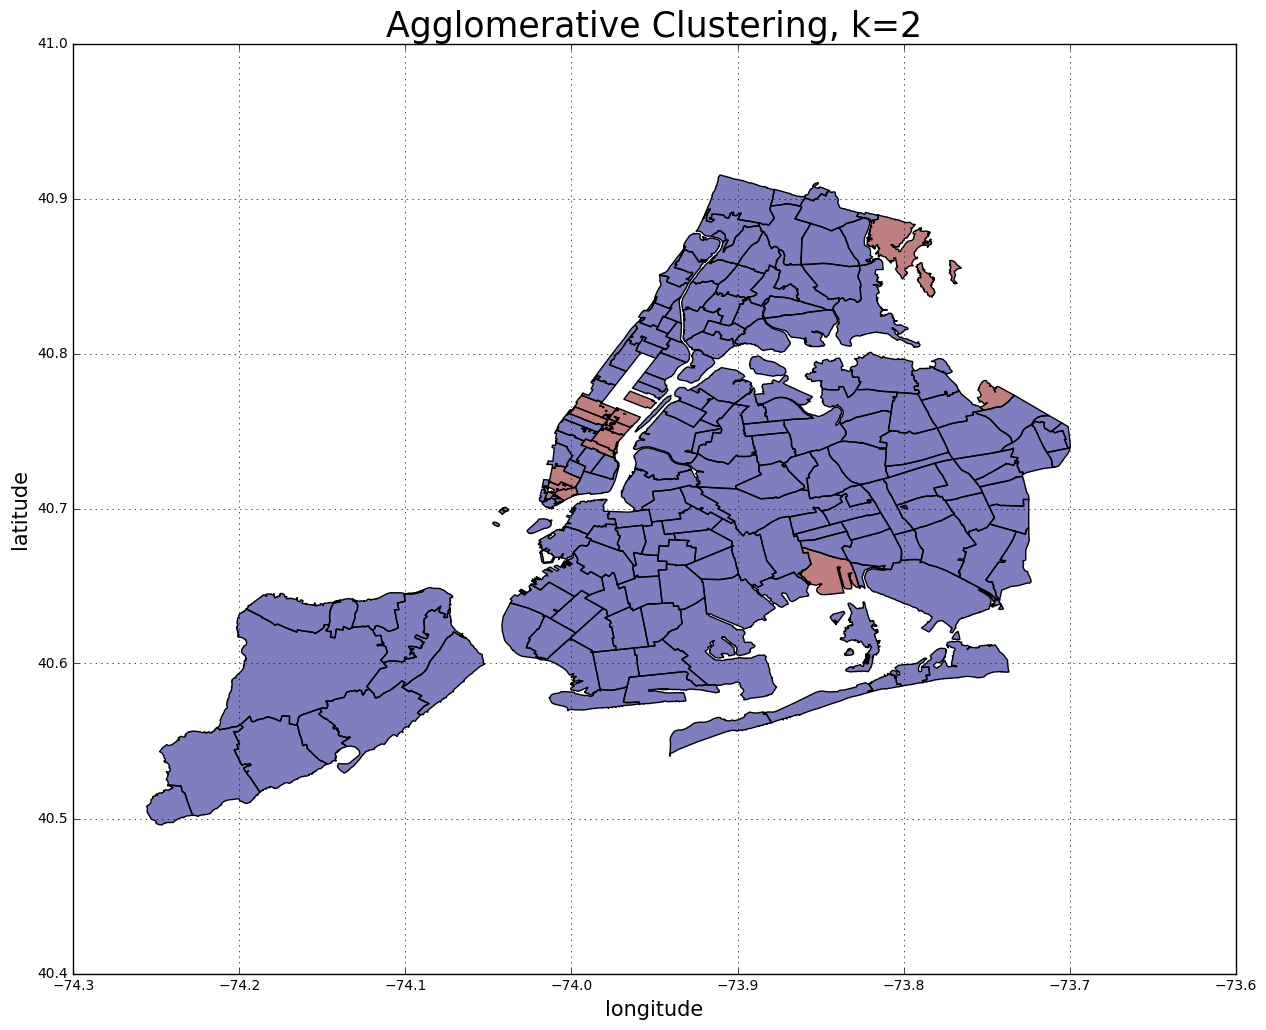

In [144]:
fig, ax = plt.subplots(figsize=(15,12))
NYCzipcode_shape.plot(column='agg2_labels', ax=ax)
ax.set_title("Agglomerative Clustering, k=2", fontsize=25)
ax.grid()
ax.set_xlabel('longitude', fontsize = 15)
ax.set_ylabel('latitude', fontsize = 15)
plt.show()

Figure 4: Agglomerative clustering with number of clusters = 2 

#### The first map uses K-Means clustering while the second map uses Agglomerative clustering.
Both maps show similar clustering in lower Manhattan. Similarly, both maps show large portions of Brooklyn being a single color which represents no or less clustering.